## Install and imports

Explicación de los modulos usados y por que

#### Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import re
from plotly.subplots import make_subplots
import seaborn as sn
import matplotlib.pyplot as plt

#### Functions

In [3]:
palette = ["#FC645F",
           "#A8E4A0",
           "#7088FF",
           "#FEB1AF"]

def dat_insights(dataframe,sheet_name=False,rtn=True,dat=False,date_parse=False):
  if type(dataframe) == str:
    dataframe = data_capture(dataframe,sheet_name,date_parse).capture()
  if dat is not False:
    dataframe = column_cleaner(dataframe,[column for column in dataframe.columns if column in dat])
  null_values = dataframe.isnull().sum().sort_values(ascending=False)
  nulls_sum = (dataframe.isnull().sum()).sum()
  fields_sum = (dataframe.shape[0] * dataframe.shape[1]) - nulls_sum
  nulls_percentile = max(null_values)
  fills_percentile = dataframe.shape[0] - nulls_percentile
  if null_values.shape[0] > 15:
    null_values = null_values[null_values != 0]
  else:
    pass
  fig = make_subplots(rows=2,
                      cols=2,
                      subplot_titles=["<b>CORRECT ENTRIES</b>",
                                      "<b>CORRECT CELLS",
                                      "<b>NULLS/COLUMN</b>"],
                      specs=[[{'type':'domain'},{'type':'domain'}],
                             [{'type':'xy',"colspan":2},{}]])
  fig.add_trace(go.Pie(labels=["Null entries","Valid entries"],
                       values=[nulls_percentile,fills_percentile],
                       hole=0.4,
                       marker_colors=palette,
                       name="Correct entries",
                       title=dataframe.shape[0],legendgroup="apie"),1,1)
  fig.add_trace(go.Pie(labels=["Null cells",
                               "Valid cells"],
                       values=[nulls_sum,
                               fields_sum],
                       hole=0.4,
                       marker_colors=palette,
                       name="Correct cells",
                       title=dataframe.shape[0]*dataframe.shape[1],
                       legendgroup="pie"),1,2)
  fig.add_trace(go.Bar(x=null_values,
                       y=null_values.index,
                       name="Nulls/Column",
                       orientation="h",
                       marker_color="#FC645F",
                       showlegend=False),2,1)
  fig.update_traces(textposition='inside')
  fig.update_layout(height=600,
                    width=800,
                    title=f"<b>{sheet_name.upper()} INSIGHTS</b>",
                    yaxis_title="Columns",
                    xaxis_title="Nulls",
                    font_size=14)
  if rtn == True:
    fig.show(config={'modeBarButtonsToAdd':['drawline',
                                            'drawopenpath',
                                            'drawclosedpath',
                                            'drawcircle',
                                            'drawrect',
                                            'eraseshape']})
  else:
    return fig


def table_dtype(dataframe,rtn=True):
  # Función que crea reporte de tipo de variables y datos
  # dataframe = objet.dataframe
  # arg = True: use fig.show() otherwise it returns fig for object
  df_dtypes = dataframe.convert_dtypes()
  table_columns = [column for column in df_dtypes.dtypes.index.values]
  table_values = [str(value) for value in df_dtypes.dtypes]
  values = pd.Series(table_values)
  fig = make_subplots(rows=2,
                      cols=2,
                      specs=[[{"type":"table"},{"type":"domain"}],
                             [{"type":"table"},{"type":"domain"}]],
                      subplot_titles=["",
                                      "<b>TYPE",
                                      "",
                                      "<b>CLASS"])
  fig.add_trace(go.Pie(labels=values.value_counts().index,
                       values=values.value_counts(),
                       marker_colors=palette,
                       hole=0.4,
                       title=values.shape[0],
                       legendgroup="pie"),1,2)
  fig.update_traces(textposition='inside')
  fig.add_trace(go.Table(header=dict(values=['Column',
                                             'Data type'],
                                     fill_color="#A8E4A0",
                                     line_color='darkslategray'),
                         cells=dict(values=[table_columns,
                                            table_values],
                                    line_color='darkslategray')),1,1)
  fig.update_layout(height=500,width=1000,
                    title="<b>DATA TYPE ANALYSIS",
                    font_size=12)

  type_var = []
  for value in range(0,len(df_dtypes.dtypes)):
    if "Int" in str(df_dtypes.dtypes[value]):
      type_var.append("Numerical")
    else:
      if len(df_dtypes[df_dtypes.dtypes.index[value]].value_counts().index) <= 2:
        type_var.append("Numerical/Boolean")
      else:
        type_var.append("Categorical")

  pie_values = [values for values in [type_var.count("Categorical"), type_var.count("Numerical"), type_var.count("Numerical/Boolean")] if values !=0]
  pie_labels = str(set(type_var)).replace("{","").replace("}","").replace("'","").split(",")
  fig.add_trace(go.Table(header=dict(values=["Columns",
                                             "Classification"],
                                     fill_color="#A8E4A0",
                                     line_color='darkslategray'),
                         cells=dict(values=[df_dtypes.dtypes.index,type_var])),2,1)
  fig.add_trace(go.Pie(labels=pie_labels,
                       values=pie_values,
                       marker_colors=palette,
                       hole=0.4,
                       legendgroup="pie2"),2,2)
  fig.update_layout(height=800,width=1000,title="<b>DATA TYPE ANALYSIS",font_size=14)
  if rtn == True:
    fig.show('png')
  else:
    return fig


def correlation_matrix(dataframe, name, rtn=True):
  dataframe = dataframe.convert_dtypes()
  fig=make_subplots(cols=1,
                    rows=1)
  z,x = dataframe.corr(method="pearson"),dataframe.corr(method="pearson").columns
  fig.add_trace(go.Heatmap(z = z,
                           x = x,
                           y = x,
                           colorscale="Burg"))
  fig.update_layout(height=800,width=800,title=f"<b>{name} FEATURE CORRELATION MATRIX")
  if rtn == True:
        fig.show(config={'modeBarButtonsToAdd':['drawline',
                                            'drawopenpath',
                                            'drawclosedpath',
                                            'drawcircle',
                                            'drawrect',
                                            'eraseshape']})
  else:
    return fig

## Exploratory Data Analysis

### Primeros pasos

Primero exportamos nuestro dataset como objecto panda.dataframe para realizar las primeras observaciones. Con la utilización del método append, head y tail, generamos una preview del dataframe basada en los diez primeros y últimos registros.

In [2]:
pd.set_option('max_columns', 9)
file = 'dataset.csv'
df = pd.read_csv(file)

df_preview = df.append([df.head(10), df.tail(10)])
df_preview

,Unnamed: 0,operation,property_type,place_name,...,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,...,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,...,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,...,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,...,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,...,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...
...,...,...,...,...,...,...,...,...,...
121215,121215,sell,apartment,Belgrano,...,http://www.properati.com.ar/1cja2_venta_depart...,TORRE FORUM ALCORTA - MÁXIMA CATEGORÍA.Impecab...,Torre Forum Alcorta- Impecable 3 ambientes,https://thumbs4.properati.com/1/bjms0KnaAnlNoQ...
121216,121216,sell,house,Beccar,...,http://www.properati.com.ar/1cja6_venta_casa_b...,Excelente e impecable casa en Venta en Las Lom...,Ruca Inmuebles | Venta | Lomas de San Isidro |...,https://thumbs4.properati.com/2/PCc3WuQDjpNZc4...
121217,121217,sell,apartment,Villa Urquiza,...,http://www.properati.com.ar/1cja7_venta_depart...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,https://thumbs4.properati.com/9/YAe_-2gRVykADP...
121218,121218,sell,apartment,Plaza Colón,...,http://www.properati.com.ar/1cja8_venta_depart...,"2 Amb al contrafrente, luminoso. El departame...",2 amb. C/ dep. de servicio al contrafrente| Re...,https://thumbs4.properati.com/8/Q12PTvU6BQJ0ib...


Con un pedido de atributo columns generamos una lista de las columnas presentes y luego consultamos el atributo shape para observa la conformación del dataframe.

In [4]:
df.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [5]:
df.shape

(121220, 26)

Al parecer contamos con dos columnas index debido a que el archivo csv incluía una columna de índice sin label. Esta columna es una primera candidata para ser eliminada, pero antes de proceder es necesario validar que efectivamente hay un match 1:1 entre ambas.
La validación mediante indexado booleano desmuestra que no parece haber ningún valor donde el índice del dataset no coincida con el índice genero al crear el dataframe, así que procedemos a su eliminación.

In [6]:
df[df['Unnamed: 0'] != df.index]

,Unnamed: 0,operation,property_type,place_name,...,properati_url,description,title,image_thumbnail


In [7]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

#### Revisando por constantes

In [8]:
def constant_check(dataframe):
    if isinstance(dataframe, pd.DataFrame) is True:
        for column in dataframe.columns:
            if len(dataframe[column].value_counts().index) == 1:
                dataframe = dataframe.drop(columns=[column])

    return dataframe


df = constant_check(df)
df

,property_type,place_name,place_with_parent_names,state_name,...,properati_url,description,title,image_thumbnail
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,...,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Bs.As. G.B.A. Zona Sur,...,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,...,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,PH,Liniers,|Argentina|Capital Federal|Liniers|,Capital Federal,...,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Buenos Aires Costa Atlántica,...,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...
...,...,...,...,...,...,...,...,...,...
121215,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,...,http://www.properati.com.ar/1cja2_venta_depart...,TORRE FORUM ALCORTA - MÁXIMA CATEGORÍA.Impecab...,Torre Forum Alcorta- Impecable 3 ambientes,https://thumbs4.properati.com/1/bjms0KnaAnlNoQ...
121216,house,Beccar,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,...,http://www.properati.com.ar/1cja6_venta_casa_b...,Excelente e impecable casa en Venta en Las Lom...,Ruca Inmuebles | Venta | Lomas de San Isidro |...,https://thumbs4.properati.com/2/PCc3WuQDjpNZc4...
121217,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Capital Federal,...,http://www.properati.com.ar/1cja7_venta_depart...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,https://thumbs4.properati.com/9/YAe_-2gRVykADP...
121218,apartment,Plaza Colón,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Buenos Aires Costa Atlántica,...,http://www.properati.com.ar/1cja8_venta_depart...,"2 Amb al contrafrente, luminoso. El departame...",2 amb. C/ dep. de servicio al contrafrente| Re...,https://thumbs4.properati.com/8/Q12PTvU6BQJ0ib...


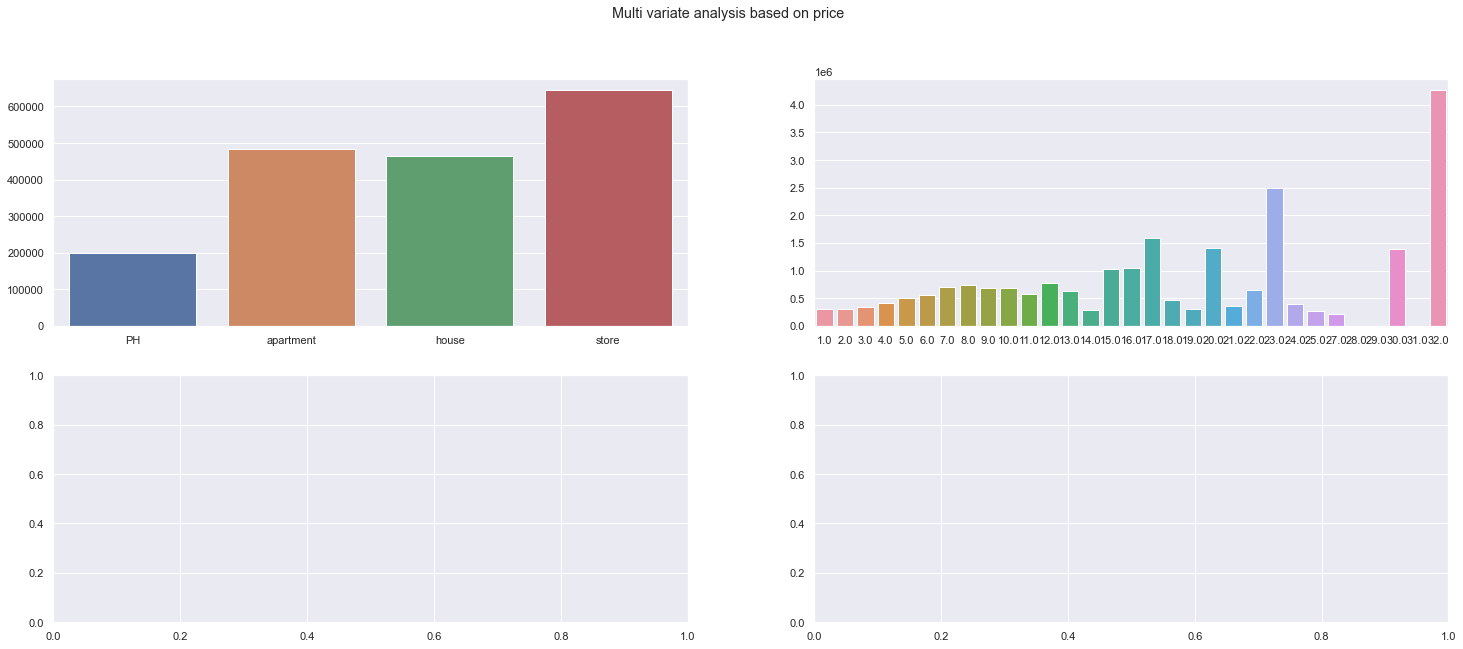

In [9]:
columns = ['property_type', 'rooms']


sn.set_theme()
fig, axes = plt.subplots(2, 2, figsize=(25, 10))
fig.suptitle('Multi variate analysis based on price')
index = 0
for column in columns:
    group_df = df[[column, 'price']]
    mean_df = group_df.groupby(by=[column]).agg({"price":['mean', 'count']})
    sn.barplot(x=mean_df.index.tolist(), y=mean_df['price']['mean'].tolist(), ax=axes[0,index])
    index += 1









In [10]:
df['rooms'] = df['rooms'].fillna(value=0).astype(int)

df.rooms.value_counts().sort_values()

28        1
29        1
31        1
24        1
27        1
23        2
32        3
25        4
30        4
19        4
21        5
18        6
22        8
20       11
16       11
17       16
15       26
14       27
13       33
12       65
11       72
9       184
10      226
8       409
7       770
6      1403
5      3782
1      7377
4      7937
2     12433
3     12567
0     73830
Name: rooms, dtype: int64

In [6]:
df_test = df.dropna()
df_test['description'] = df_test['description'].apply(lambda x: x.lower())

df_test['description'].isin(['venta']).sum()


C:\Users\Joaco\AppData\Local\Temp\ipykernel_13508\3725951666.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0

In [7]:
# que dropear:
# operation
# lat-long sacarla
# price_aprox_local_curerncy
# property_url
# image thumbnail
# rooms
# country_name

#armar:
# ambientes a partir de description



df['state_name'].value_counts()

Capital Federal                 32316
Bs.As. G.B.A. Zona Norte        25560
Bs.As. G.B.A. Zona Sur          13952
Córdoba                         12069
Santa Fe                        10172
Buenos Aires Costa Atlántica    10006
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Interior            2291
Río Negro                         808
Neuquén                           733
Mendoza                           681
Tucumán                           674
Corrientes                        583
Misiones                          464
Entre Ríos                        369
Salta                             278
Chubut                            259
San Luis                          252
La Pampa                          157
Formosa                            65
Chaco                              57
San Juan                           40
Tierra Del Fuego                   31
Catamarca                          27
Jujuy                              26
Santa Cruz                         20
Santiago Del

In [8]:
df['currency'].value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

In [9]:
df['state_name'].value_counts()

Capital Federal                 32316
Bs.As. G.B.A. Zona Norte        25560
Bs.As. G.B.A. Zona Sur          13952
Córdoba                         12069
Santa Fe                        10172
Buenos Aires Costa Atlántica    10006
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Interior            2291
Río Negro                         808
Neuquén                           733
Mendoza                           681
Tucumán                           674
Corrientes                        583
Misiones                          464
Entre Ríos                        369
Salta                             278
Chubut                            259
San Luis                          252
La Pampa                          157
Formosa                            65
Chaco                              57
San Juan                           40
Tierra Del Fuego                   31
Catamarca                          27
Jujuy                              26
Santa Cruz                         20
Santiago Del

In [10]:
df.shape

(121220, 26)

In [11]:
df.dtypes

Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                           int32
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

In [12]:
table_dtype(df)

In [6]:
fig = correlation_matrix(df, "adasd")

In [7]:
df_1 = df[['state_name', 'price']]
df_1

,state_name,price
0,Capital Federal,62000.0
1,Bs.As. G.B.A. Zona Sur,150000.0
2,Capital Federal,72000.0
3,Capital Federal,95000.0
4,Buenos Aires Costa Atlántica,64000.0
...,...,...
121215,Capital Federal,870000.0
121216,Bs.As. G.B.A. Zona Norte,498000.0
121217,Capital Federal,131500.0
121218,Buenos Aires Costa Atlántica,95900.0


In [ ]:

#x = dat_insights(df, 'EDA', rtn=True)
#x